# Plot syllable waveforms

In [1]:
import toml
import numba
import joblib
import random
import warnings
import numpy as np
import rl_analysis
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from os.path import join
from scipy import signal
from rl_analysis.bootstraps import bootstrap_ci
from rl_analysis.behavior.moseq import syll_onset
from rl_analysis.io.df import dlight_exclude_toml, NONSYLL_COLS
from rl_analysis.photometry.windowing import window_trials_as_mtx
from rl_analysis.plotting import (
    setup_plotting_env,
    clean_ticks,
    save_factory,
    add_legend,
    bootstrap_lineplot,
    fg,
    COLORS
)

warnings.simplefilter("ignore")
numba.set_num_threads(6)

In [6]:
with open("../analysis_configuration.toml", "r") as f:
    config = toml.load(f)

setup_plotting_env()

saver = save_factory(join(config['figures']['store_dir'], 'fig-01'), tight_layout=False)

## Loading and setup

In [3]:
use_dct = dlight_exclude_toml(
    join(config['raw_data']['dlight'], 'dlight_photometry_processed_full.toml'),
    **config["dlight_common"]
)

df = pd.read_parquet(
    join(config['raw_data']['dlight'], 'dlight_photometry_processed_full.parquet'),
    filters=[("uuid", "in", list(use_dct)), ("area", "=", "dls")],
)

df = df[~df['session_number'].isin([3, 4])]
df = df.drop(columns=NONSYLL_COLS)
df = df.sort_index()

df['offline onset'] = False
df.loc[df.index[syll_onset(df['predicted_syllable (offline)'])], 'offline onset'] = True

In [4]:
# use prev sorting for comparison
sorting = joblib.load(join(config['intermediate_results']['dlight'], 'fig1-syllable-sorting.p'))

In [5]:
def circ_shuff_py(v):
    return np.roll(v.to_numpy(), random.randint(1, len(v) - 1))


def dlight_filter(ser):
    soscoeffs = signal.bessel(1, 1 / (30 / 2.), btype="high", output="sos")
    sig = ser.dropna()
    new_ser = pd.Series(index=ser.index)
    new_ser.loc[sig.index] = signal.sosfiltfilt(soscoeffs, sig)
    return new_ser

In [7]:
df["dlight filtered"] = df.groupby("uuid", sort=False, observed=True)[
    "signal_reref_dff_z"
].transform(dlight_filter)

In [8]:
time_window = (-1.5, 1.5)
syll_key = "predicted_syllable (offline)"
dlight_key = "dlight filtered"

## Panel - example syllable waveforms at top and bottom of heatmap

In [9]:
quantile_ylims = (-82, 148)
avg_ylims = (-13, 34)

In [10]:
_cp = sns.color_palette('RdBu_r', 20)
blue = _cp[0]
red = _cp[-1]

In [11]:
pos_syll = list(sorting)[0]
neg_syll = list(sorting)[-1]

pos_syll, neg_syll

(41, 59)

### Positive waveform

In [12]:
boot = 1_000

In [13]:
inds = np.where(df["offline onset"] & (df[syll_key] == pos_syll))[0]
pos_time, pos_waveforms = window_trials_as_mtx(
    df, inds, dlight_key, truncation_window=time_window, zscore_signal=True
)

In [14]:
pos_boot = bootstrap_ci(pos_waveforms, n_boots=boot)
pos_boot = pd.concat(
    pd.DataFrame({"trial": i, "trace": trace, "time": pos_time, "type": "dLight"})
    for i, trace in enumerate(pos_boot)
)

In [15]:
shuff_pos_waveforms = []

inds = np.where(df["offline onset"] & (df[syll_key] == pos_syll))[0]

for i in tqdm(range(boot)):

    time, trials = window_trials_as_mtx(
        df,
        inds + np.array(list(map(lambda v: random.randint(-60, 60), range(len(inds))))),
        dlight_key,
        truncation_window=time_window,
        zscore_signal=True,
    )
    shuff_pos_waveforms.append(pd.Series(np.nanmean(trials, axis=0), index=time))

# SAVE SHUFFLES
joblib.dump(
    shuff_pos_waveforms,
    join(config['intermediate_results']['dlight'], 'fig1-positive-filtered-waveform-shuffles.p')
)

  0%|          | 0/1000 [00:00<?, ?it/s]

['/n/groups/datta/win/dopamine-data-release/zenodo-test/dlight_intermediate_results/fig1-positive-filtered-waveform-shuffles.p']

In [16]:
# comment if you want to run the shuffles above
# shuff_pos_waveforms = joblib.load(
#     join(config['intermediate_results']['dlight'], 'fig1-positive-filtered-waveform-shuffles.p')
# )

In [17]:
shuff_pos_waveforms = np.array(shuff_pos_waveforms)
shuff_pos_boot = pd.concat(
    pd.DataFrame({"trial": i, "trace": trace, "time": pos_time, "type": "Shuffle"})
    for i, trace in enumerate(shuff_pos_waveforms)
)
shuff_z_params = shuff_pos_boot.groupby("time")["trace"].agg(["mean", "std"])

In [18]:
# rescale dlight and shuffle traces
pos_boot_z = []
for t, _trial_df in pos_boot.groupby("trial"):
    _trial_df = _trial_df.copy()
    _trial_df["z_trace"] = (
        _trial_df["trace"] - shuff_z_params["mean"].to_numpy()
    ) / shuff_z_params["std"].to_numpy()
    pos_boot_z.append(_trial_df)
pos_boot_z = pd.concat(pos_boot_z)

shuff_pos_boot_z = []
for t, _trial_df in shuff_pos_boot.groupby("trial"):
    _trial_df = _trial_df.copy()
    _trial_df["z_trace"] = (
        _trial_df["trace"] - shuff_z_params["mean"].to_numpy()
    ) / shuff_z_params["std"].to_numpy()
    shuff_pos_boot_z.append(_trial_df)
shuff_pos_boot_z = pd.concat(shuff_pos_boot_z)

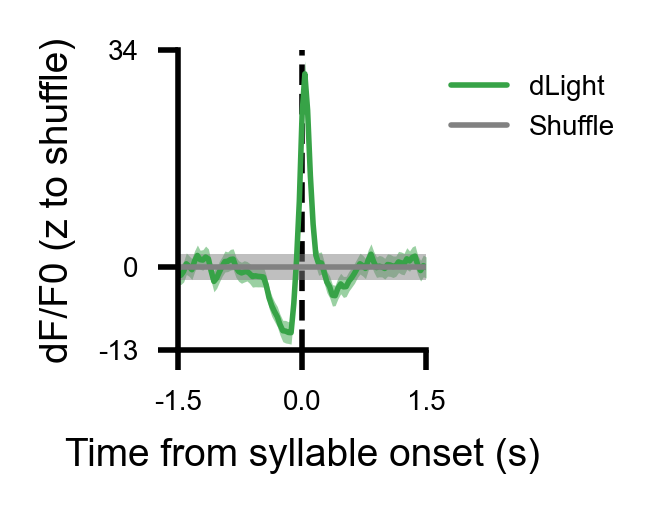

In [19]:
fig = fg(0.8, 0.975)
fig.dpi = 200
ax = bootstrap_lineplot(pos_boot_z, "time", "z_trace", color=COLORS["green"], ci=95, label="dLight")
bootstrap_lineplot(
    shuff_pos_boot_z, "time", "z_trace", color=COLORS["gray"], ci="sd", label="Shuffle", ax=ax
)
ax.axvline(0, color="k", linestyle="--", linewidth=1, zorder=-5)
ax.set(
    ylabel="dF/F0 (z to shuffle)",
    xlabel="Time from syllable onset (s)",
    xlim=time_window,
    ylim=avg_ylims,
)
clean_ticks(ax, axis="x", dtype=float, precision=1)
clean_ticks(ax, axis="y", zero_symmetry=False, dtype=int)
sns.despine()
add_legend()
saver(fig, "pos-syllable-aligned-filtered-dlight-grand-average-shuffle-z");

#### Positive quantile

In [20]:
cmap = sns.blend_palette(['#fff', COLORS['green'], '#000'], 10)
cmap

[(1.0, 1.0, 1.0),
 (0.8279307958477509, 0.9209411764705883, 0.8418823529411765),
 (0.6558615916955017, 0.8418823529411765, 0.6837647058823529),
 (0.47764705882352954, 0.76, 0.52),
 (0.3055778546712804, 0.6809411764705883, 0.36188235294117654),
 (0.19185236447520188, 0.5672156862745098, 0.24815686274509807),
 (0.1443137254901961, 0.4266666666666667, 0.1866666666666667),
 (0.09507727797001155, 0.28109803921568627, 0.12298039215686277),
 (0.047538638985005766, 0.14054901960784316, 0.06149019607843137),
 (0.0, 0.0, 0.0)]

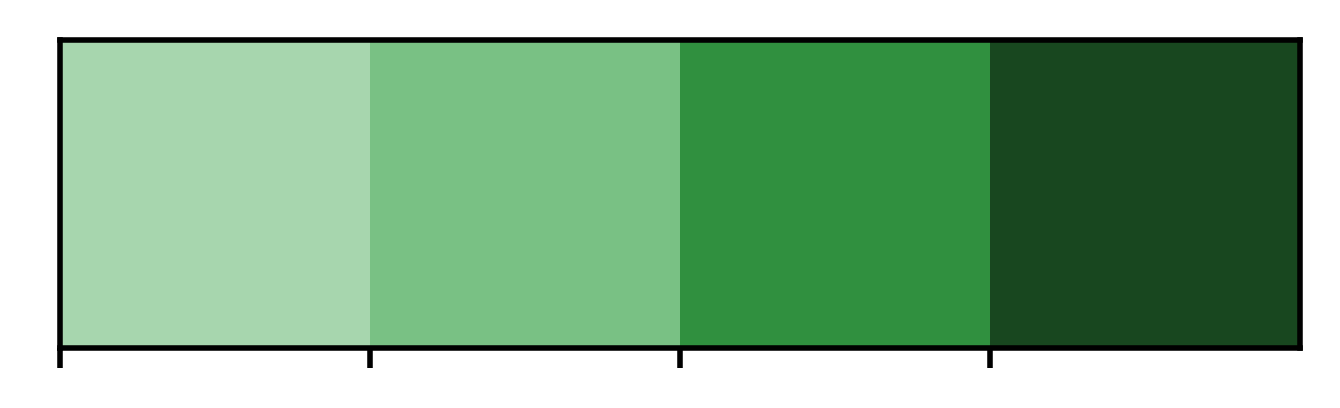

In [21]:
sns.palplot(np.array(cmap)[[2, 3, 5, 7]])

In [22]:
inds = np.where(df["offline onset"] & (df[syll_key] == pos_syll))[0]
pos_time, pos_waveforms = window_trials_as_mtx(
    df, inds, "signal_reref_dff_z", truncation_window=time_window, zscore_signal=True
)

In [23]:
avg_pos_dlight = np.nanquantile(pos_waveforms[:, (pos_time > 0) & (pos_time < 0.3)], 0.95, axis=1)
qs = pd.qcut(avg_pos_dlight, 4, labels=False)

In [24]:
inds = np.where(df["offline onset"] & (df[syll_key] == pos_syll))[0]
pos_time, pos_waveforms = window_trials_as_mtx(
    df, inds, dlight_key, truncation_window=time_window, zscore_signal=True
)

In [25]:
quantile_waveforms = []
for i in range(4):
    _wf = pos_waveforms[qs == i]
    _q_boot = bootstrap_ci(
        (_wf - shuff_z_params["mean"].to_numpy()[None, :])
        / shuff_z_params["std"].to_numpy()[None, :],
        n_boots=boot,
    )
    quantile_waveforms.append(
        pd.concat(
            pd.DataFrame({"trial": t, "trace": trace, "time": pos_time, "type": "dLight"})
            for t, trace in enumerate(_q_boot)
        )
    )

(-82.79365796805021, 149.51056164994293)


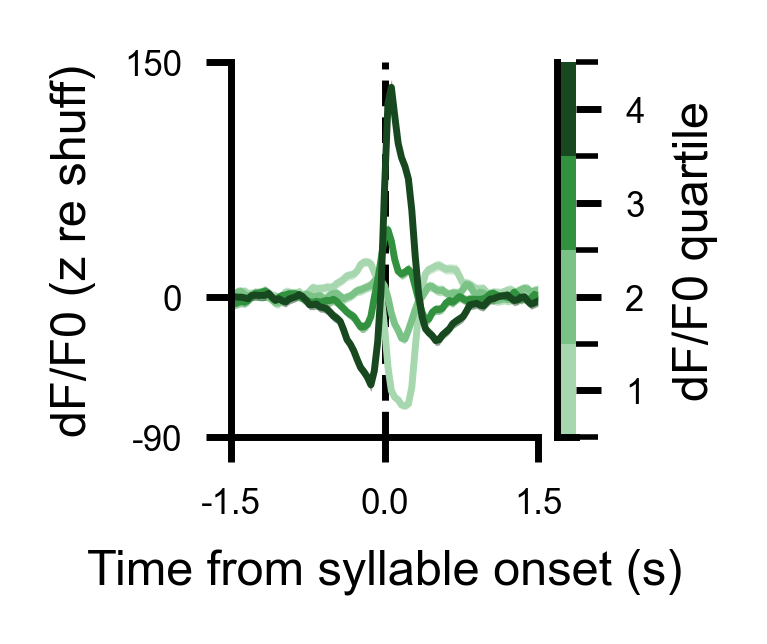

In [26]:
plt_colors = np.array(cmap)[[2, 3, 5, 7]]

fig = fg(0.99, 0.975)
fig.dpi = 250
ax = fig.gca()
for color, w in zip(plt_colors, quantile_waveforms):
    bootstrap_lineplot(w, "time", "trace", ci=95, color=color)
plt.xlim(*time_window)
clean_ticks(ax, axis="x", zero_symmetry=True, dtype=float, precision=1)
print(plt.ylim())
plt.ylim(*quantile_ylims)
clean_ticks(ax, axis="y", zero_symmetry=False, dtype=int, precision=-1)
plt.axvline(0, linewidth=1, color="k", zorder=-5, linestyle="--")
plt.xlabel("Time from syllable onset (s)")
plt.ylabel("dF/F0 (z re shuff)")
norm = mpl.colors.BoundaryNorm(np.arange(0.5, 4.6, 1), 4)
cb = fig.colorbar(
    mpl.cm.ScalarMappable(
        norm=norm,
        cmap=mpl.colors.ListedColormap(
            plt_colors,
        ),
    ),
    orientation="vertical",
    label="dF/F0 quartile",
    ax=plt.gca(),
)
cb.set_ticks(range(1, 5))
sns.despine()
cb.outline.set_visible(False)
saver(fig, 'positive-filtered-waveform-quartiles');

### Negative waveform

In [27]:
inds = np.where(df["offline onset"] & (df[syll_key] == neg_syll))[0]
neg_time, neg_waveforms = window_trials_as_mtx(
    df, inds, dlight_key, truncation_window=time_window, zscore_signal=True
)

In [28]:
neg_boot = bootstrap_ci(neg_waveforms, n_boots=boot)
neg_boot = pd.concat(
    pd.DataFrame({"trial": i, "trace": trace, "time": neg_time, "type": "dLight"})
    for i, trace in enumerate(neg_boot)
)

In [29]:
shuff_neg_waveforms = []
shuff_key = "shuff_dlight"

inds = np.where(df["offline onset"] & (df[syll_key] == neg_syll))[0]

for i in tqdm(range(boot)):

    df[shuff_key] = circ_shuff_py(df[dlight_key])
    time, trials = window_trials_as_mtx(
        df, inds, shuff_key, truncation_window=time_window, zscore_signal=True
    )

    shuff_neg_waveforms.append(pd.Series(np.nanmean(trials, axis=0), index=time))

# SAVE SHUFFLES
joblib.dump(
    shuff_neg_waveforms,
    join(config['intermediate_results']['dlight'], 'fig1-negative-filtered-waveform-shuffles.p')
)

  0%|          | 0/1000 [00:00<?, ?it/s]

['/n/groups/datta/win/dopamine-data-release/zenodo-test/dlight_intermediate_results/fig1-negative-filtered-waveform-shuffles.p']

In [30]:
# comment if you want to run the shuffles above
# shuff_neg_waveforms = joblib.load(
#     join(config['intermediate_results']['dlight'], 'fig1-negative-filtered-waveform-shuffles.p')
# )

In [31]:
shuff_neg_waveforms = np.array(shuff_neg_waveforms)
shuff_neg_boot = pd.concat(
    pd.DataFrame({"trial": i, "trace": trace, "time": neg_time, "type": "Shuffle"})
    for i, trace in enumerate(shuff_neg_waveforms)
)
shuff_z_params = shuff_neg_boot.groupby("time")["trace"].agg(["mean", "std"])

In [32]:
# rescale dlight and shuffle traces
neg_boot_z = []
for t, _trial_df in neg_boot.groupby("trial"):
    _trial_df = _trial_df.copy()
    _trial_df["z_trace"] = (
        _trial_df["trace"] - shuff_z_params["mean"].to_numpy()
    ) / shuff_z_params["std"].to_numpy()
    neg_boot_z.append(_trial_df)
neg_boot_z = pd.concat(neg_boot_z)

shuff_neg_boot_z = []
for t, _trial_df in shuff_neg_boot.groupby("trial"):
    _trial_df = _trial_df.copy()
    _trial_df["z_trace"] = (
        _trial_df["trace"] - shuff_z_params["mean"].to_numpy()
    ) / shuff_z_params["std"].to_numpy()
    shuff_neg_boot_z.append(_trial_df)
shuff_neg_boot_z = pd.concat(shuff_neg_boot_z)

(-6.24535626288147, 5.171339929343223)


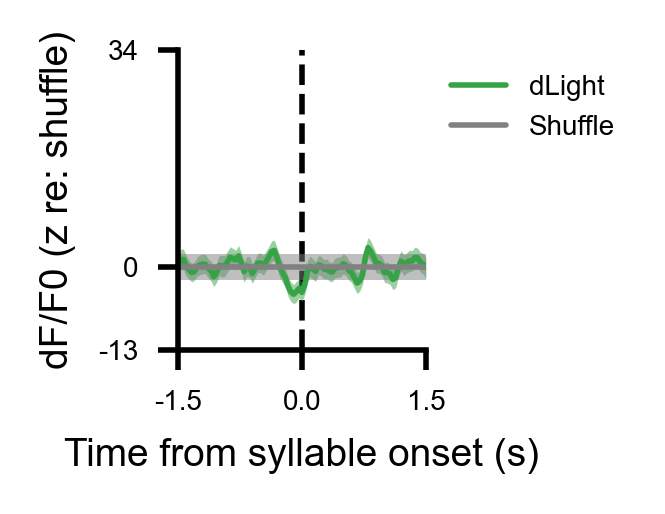

In [33]:
fig = fg(0.8, 0.975)
fig.dpi = 200
ax = bootstrap_lineplot(neg_boot_z, 'time', 'z_trace', color=COLORS["green"], ci=95, label='dLight')
bootstrap_lineplot(shuff_neg_boot_z, 'time', 'z_trace', color=COLORS["gray"], ci='sd', label='Shuffle')
plt.axvline(0, color='k', linestyle='--', linewidth=1, zorder=-5)
print(plt.ylim())
plt.ylabel('dF/F0 (z re: shuffle)')
plt.xlabel('Time from syllable onset (s)')
plt.xlim(*time_window)
clean_ticks(ax, axis="x", dtype=float, precision=1)
plt.ylim(*avg_ylims)
clean_ticks(ax, axis="y", zero_symmetry=False, dtype=int)
sns.despine()
add_legend()
saver(fig, 'neg-syllable-aligned-filtered-dlight-grand-average-shuffle-z');

#### Quantiles

In [34]:
inds = np.where(df["offline onset"] & (df[syll_key] == neg_syll))[0]
neg_time, neg_waveforms = window_trials_as_mtx(
    df, inds, "signal_reref_dff_z", truncation_window=time_window, zscore_signal=True
)

In [35]:
# avg_pos_dlight = np.nanmean(pos_waveforms[:, (neg_time > 0) & (neg_time < 0.3)], axis=1)
avg_neg_dlight = np.nanquantile(neg_waveforms[:, (neg_time > 0) & (neg_time < 0.3)], 0.95, axis=1)
qs = pd.qcut(avg_neg_dlight, 4, labels=False)

In [36]:
inds = np.where(df["offline onset"] & (df[syll_key] == neg_syll))[0]
neg_time, neg_waveforms = window_trials_as_mtx(
    df, inds, dlight_key, truncation_window=time_window, zscore_signal=True
)

In [37]:
quantile_waveforms = []
for i in range(4):
    _wf = neg_waveforms[qs == i]
    _q_boot = bootstrap_ci(
        (_wf - shuff_z_params["mean"].to_numpy()[None, :])
        / shuff_z_params["std"].to_numpy()[None, :],
        n_boots=boot,
    )
    quantile_waveforms.append(
        pd.concat(
            pd.DataFrame({"trial": t, "trace": trace, "time": neg_time, "type": "dLight"})
            for t, trace in enumerate(_q_boot)
        )
    )

(-48.11612089361971, 58.55283994617758)


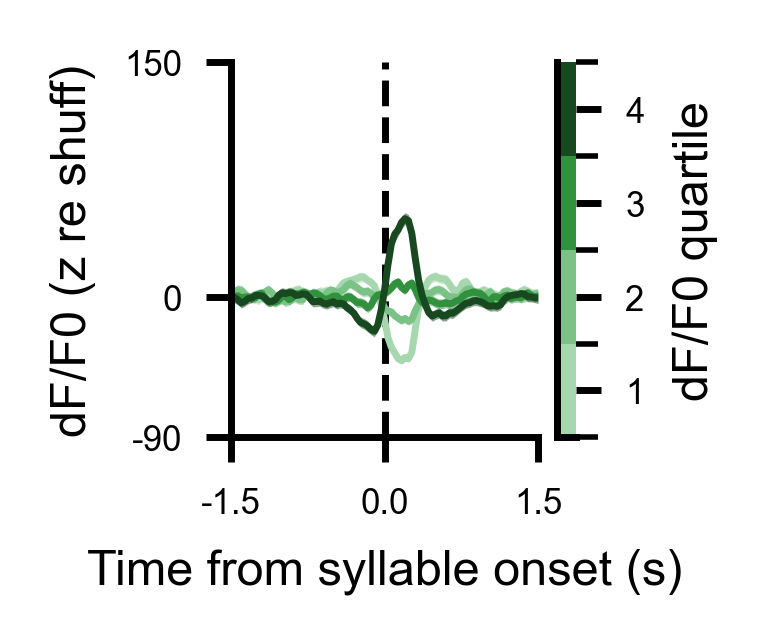

In [38]:
plt_colors = np.array(cmap)[[2, 3, 5, 7]]

fig = fg(0.99, 0.975)
fig.dpi = 250
ax = fig.gca()
for color, w in zip(plt_colors, quantile_waveforms):
    bootstrap_lineplot(w, "time", "trace", ci=95, color=color)
# plt.xlim(*time_window)
plt.xlim(-1.5, 1.5)
clean_ticks(ax, axis="x", zero_symmetry=True, dtype=float, precision=1)
print(plt.ylim())
plt.ylim(*quantile_ylims)
clean_ticks(ax, axis="y", zero_symmetry=False, dtype=int, precision=-1)
plt.axvline(0, linewidth=1, color="k", zorder=-5, linestyle="--")
plt.xlabel("Time from syllable onset (s)")
plt.ylabel("dF/F0 (z re shuff)")
norm = mpl.colors.BoundaryNorm(np.arange(0.5, 4.6, 1), 4)
cb = fig.colorbar(
    mpl.cm.ScalarMappable(
        norm=norm,
        cmap=mpl.colors.ListedColormap(
            plt_colors
        ),
    ),
    orientation="vertical",
    label="dF/F0 quartile",
    ax=plt.gca(),
)
cb.set_ticks(range(1, 5))
cb.outline.set_visible(False)
sns.despine()
saver(fig, 'negative-filtered-waveform-quartiles');